# ML techniques on MedMNIST-Pneumonia dataset
#### This is the project for the 2023/2024 ML class in Tor Vergata University
##### Author: Staccone Simone 0324525

## Introduction
The aim of this project is to apply different ML techniques to the MedMINST-Pneumonia dataset. The main goal is to use this dataset to train ML models in order to help doctors in their diagnosis, therefore the main focus will be on minimizing the number of instances which are affected by pneumonia, but are missclassified (false negatives).

In particular, this notebook will present three different ML model usefull for binary classification to supply to that task:
- Logistic Regression
- Random Forest
- CNN (Convolutional Neural Network)

The main goal is to optimize the predictions on the linear regression and the CNN model, due the fact that random forest is used to compare the performances obtained in the other two models.

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn import metrics

from sklearn import preprocessing

from sklearn.metrics import  accuracy_score, classification_report

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier

import keras

from keras.callbacks import EarlyStopping 

2024-01-29 23:41:58.425776: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-29 23:41:58.431440: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-29 23:41:58.514237: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-29 23:41:58.514297: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-29 23:41:58.516374: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Data pre-processing
The first thing to do is to load the data, whihch is present in two files .npy, the first containing the vector representation of the input images (28x28) and the second file containing the label of the images {0,1} -> {Doesn't have pneumonia, Has pneumonia}.

Secondly I want to flatten the image, so that I have a single input vector of length 784 (28*28).

In addtion, I'm rescaling the single pixels to get values normalized between x<sub>max</sub> and x<sub>min</sub>, therefore for each value of the pixel in input I want to have:
$\hat{x_j} = \frac{x_j - x_{min}}{x_{max} - x_{min}}$


In [2]:
# Load the data
X = np.load("pneumonia_images.npy")
y = np.load("pneumonia_labels.npy")

# Rescale to get shape (# of instances, 28*28, 1), normalized between X_max and X_min
scaler = preprocessing.MinMaxScaler()
x_reshaped = X.reshape( (np.shape(X)[0],np.shape(X)[1]*np.shape(X)[2]) )
y_reshaped = y.reshape(np.shape(y)[0])

new_X = scaler.fit_transform( x_reshaped  )

x_dim,y_dim,z_dim = np.shape(X)

if(x_dim == np.size(y)):
    print("Dataset is composed by " + str(x_dim) + " images with dimension: " + str(y_dim) + "x" + str(z_dim))
else:
    raise Exception("[ERROR] Dataset isn't formatted well: different numbers of images and labels")


Dataset is composed by 5232 images with dimension: 28x28


In [3]:
k = 0
for i in y:
    if i == 1:
        k = k + 1
print("In the dataset we have: " + str(k) + " examples classified has pneumonia")
print("In the dataset we have: " + str(np.size(y) - k) + " examples classified has NOT-pneumonia")




In the dataset we have: 3883 examples classified has pneumonia
In the dataset we have: 1349 examples classified has NOT-pneumonia


In [4]:
print("Here's how actually the nomralized data looks like")
new_X[0][1:10]

Here's how actually the nomralized data looks like


array([0.45378151, 0.48347107, 0.46638655, 0.4279661 , 0.37974684,
       0.28571429, 0.19678715, 0.11155378, 0.23529412])

In [4]:
x_train, x_test, y_train, y_test = train_test_split(new_X, y_reshaped, test_size=0.2, random_state=0)

In [6]:
def show_pneumonia_in_dataset(y,label):
    k = 0
    for i in y:
        if i == 1:
            k = k + 1
    print("In the " + str(label) + " dataset we have: " + str(k) + " examples classified has pneumonia")
    print("In the " + str(label) + " dataset we have: " + str(np.size(y) - k) + " examples classified has NOT-pneumonia")


In [7]:
# Debug function, to check dataset composition
show_pneumonia_in_dataset(y_train, "train")
show_pneumonia_in_dataset(y_test, "test")


In the train dataset we have: 3121 examples classified has pneumonia
In the train dataset we have: 1064 examples classified has NOT-pneumonia
In the test dataset we have: 762 examples classified has pneumonia
In the test dataset we have: 285 examples classified has NOT-pneumonia


In [8]:
print("Dataset total size is: \t" + str(np.shape(new_X)) )
print("Training set size is: \t" + str(np.shape(x_train)) )
print("Testing set size is: \t" + str(np.shape(x_test)) )

print("Dataset total size is: \t" + str(np.size(y)) )
print("Training set size is: \t" + str(np.size(y_train)) )
print("Testing set size is: \t" + str(np.size(y_test)) )

Dataset total size is: 	(5232, 784)
Training set size is: 	(4185, 784)
Testing set size is: 	(1047, 784)
Dataset total size is: 	5232
Training set size is: 	4185
Testing set size is: 	1047


## Data Visualization

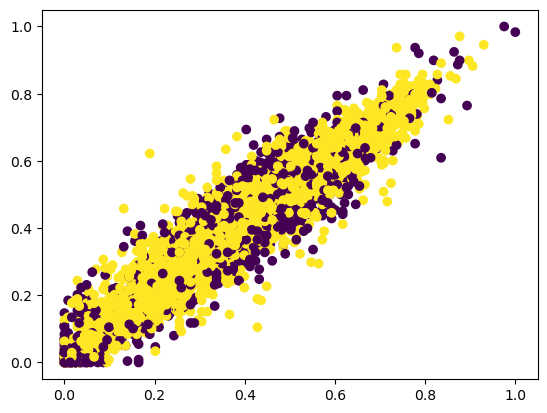

In [9]:
plt.scatter(new_X[:,0],new_X[:,1],c=y)

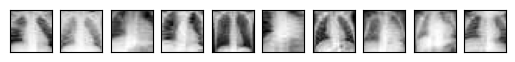

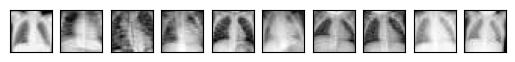

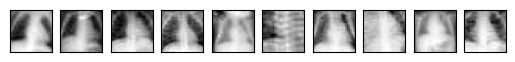

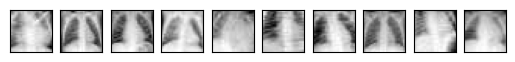

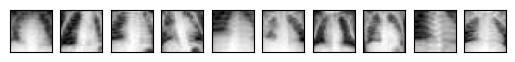

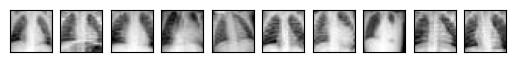

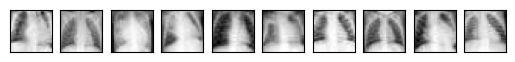

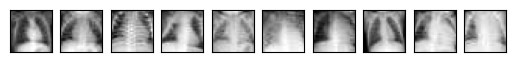

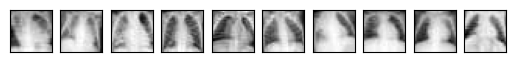

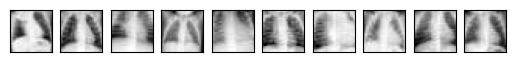

In [10]:
for i in range(0,100,10):
    for j in range(1,11):
        plt.subplot(5,10,j)
        frame = plt.imshow(X[i+j], cmap=plt.get_cmap('gray'))
        frame.axes.get_xaxis().set_ticks([]) # Hide x axis
        frame.axes.get_yaxis().set_ticks([]) # Hide y axis
    plt.show()

## Logistic Regression

In [11]:
# Instance of the model
logisticRegr = LogisticRegression(C = 1,solver = 'lbfgs',penalty="l2", class_weight='balanced')

# Train the model
logisticRegr.fit(x_train, y_train)

# Test the model
predictions = logisticRegr.predict(x_test)
show_pneumonia_in_dataset(predictions, "predictions")
show_pneumonia_in_dataset(y_reshaped, "test")


# Get accuracy
accuracy = logisticRegr.score(x_test, y_test)
print("Accuracy is: " + str(accuracy))

# Get all measurement according to permormance metrics
report=classification_report(y_true=y_test, y_pred=predictions,labels=[0,1],target_names=['No','Yes'])
print(report)
print(accuracy_score(y_test, predictions))

In the predictions dataset we have: 734 examples classified has pneumonia
In the predictions dataset we have: 313 examples classified has NOT-pneumonia
In the test dataset we have: 3883 examples classified has pneumonia
In the test dataset we have: 1349 examples classified has NOT-pneumonia
Accuracy is: 0.9617956064947469
              precision    recall  f1-score   support

          No       0.89      0.98      0.93       285
         Yes       0.99      0.96      0.97       762

    accuracy                           0.96      1047
   macro avg       0.94      0.97      0.95      1047
weighted avg       0.96      0.96      0.96      1047

0.9617956064947469


I want to minimize the number of predictions where the image has pneumonia but the regression miss classify it (Actual = 1, Predicted = 0), so I want to minimize false negatives and therefore maximize the recall

Misclassified instances are: 40


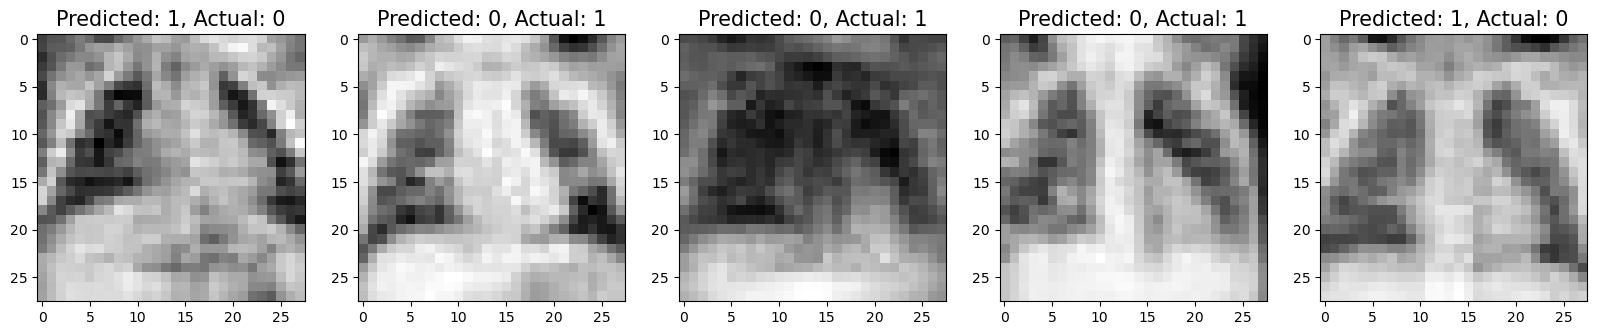

In [12]:
# Get missclassified data
index = 0
misclassifiedIndexes = []
for label, predict in zip(y_test, predictions):
    if label != predict: 
        misclassifiedIndexes.append(index)
    index +=1
    
print("Misclassified instances are: " + str( len(misclassifiedIndexes) ))
# Show a subset of missclassified data
plt.figure(figsize=(20,4))
for plotIndex, badIndex in enumerate(misclassifiedIndexes[0:5]):
    plt.subplot(1, 5, plotIndex + 1)
    plt.imshow(np.reshape(x_test[badIndex], (28,28)), cmap=plt.cm.gray)
    plt.title('Predicted: {}, Actual: {}'.format(predictions[badIndex], y_test[badIndex]), fontsize = 15)

In the predictions dataset we have: 734 examples classified has pneumonia
In the predictions dataset we have: 313 examples classified has NOT-pneumonia
Total number of test instances: 1047
Total number of predictions: 1047
Class 1: 
TN FP
FN TP


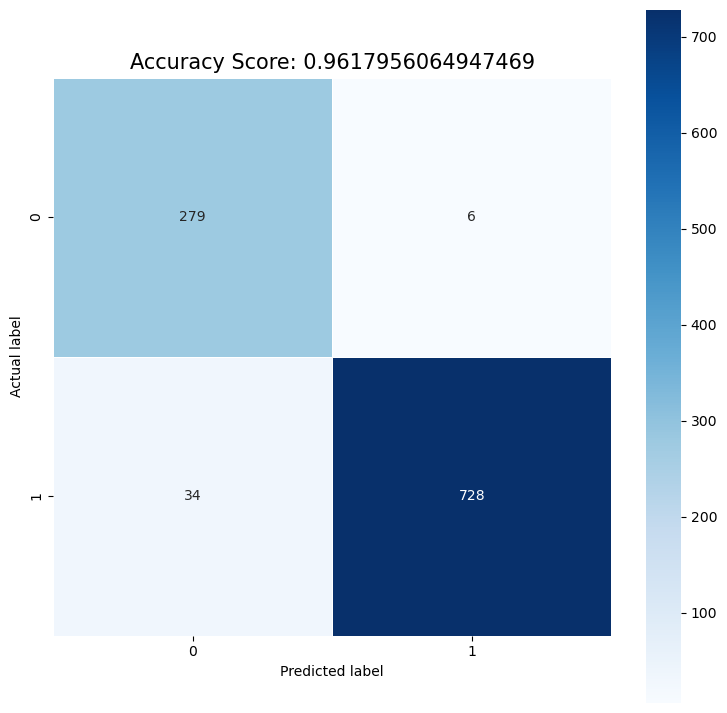

In [13]:
show_pneumonia_in_dataset(predictions, "predictions")


# Visualize performance
cm = metrics.confusion_matrix(y_true=y_test, y_pred=predictions)
print("Total number of test instances: " + str(y_test.size))
print("Total number of predictions: " + str(predictions.size))
print('Class 1: ')
print('TN FP')
print('FN TP')

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15);
plt.show()

### Try with tuning of C

In [5]:
C = np.arange (0.01, 10, 0.02)

print("Input data shape:")
print('x_train: ' + str(np.shape(x_train)))
print('y_train: ' + str(np.shape(y_train)))
print('')


new_X_train, new_X_validation, new_Y_train, new_Y_validation = train_test_split(x_train, y_train, test_size=0.25, random_state=0)

print("Data shape after splitting:")
print('new_X_train: ' + str(np.shape(new_X_train)))
print('new_X_validation: ' + str(np.shape(new_X_validation)))
print('new_y_train: ' + str(np.shape(new_Y_train)))
print('new_y_validation' + str(np.shape(new_Y_validation)))



Input data shape:
x_train: (4185, 784)
y_train: (4185,)

Data shape after splitting:
new_X_train: (3138, 784)
new_X_validation: (1047, 784)
new_y_train: (3138,)
new_y_validation(1047,)


In [ ]:
recallList = []
max_recall = [0,0] # [Best racall value, best C value]

for c in C:
    logisticRegrToTune = LogisticRegression(C = c, solver = 'lbfgs',penalty="l2", class_weight='balanced')
    logisticRegrToTune.fit(new_X_train, new_Y_train)
    predictions = logisticRegrToTune.predict(new_X_validation)
    recall = metrics.recall_score(new_Y_validation, predictions,pos_label = 1,average = 'binary')
    if max_recall[0] < recall:
        max_recall = [recall,c]
    recallList.append(recall)
    
array_di_valori = np.array(recallList)
plt.plot(C,recallList)

plt.xlabel('C Value')
plt.ylabel('Recall')
plt.title('Recall according to different C')

plt.show()


In [15]:
max_recall

[0.9687108886107635, 7.849999999999999]

In [16]:
logisticRegr = LogisticRegression(C = max_recall[1],solver = 'lbfgs',penalty="l2", class_weight='balanced')
logisticRegr.fit(x_train, y_train)
predictions = logisticRegr.predict(x_test)
accuracy = logisticRegr.score(x_test, y_test)
print("Accuracy is: " + str(accuracy))
report=classification_report(y_test,predictions)
print(report)

Accuracy is: 0.9579751671442216
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       285
           1       0.98      0.96      0.97       762

    accuracy                           0.96      1047
   macro avg       0.94      0.95      0.95      1047
weighted avg       0.96      0.96      0.96      1047



In [17]:
recall = metrics.recall_score(y_test, predictions,pos_label = 1,average = 'binary')
recall

0.9619422572178478

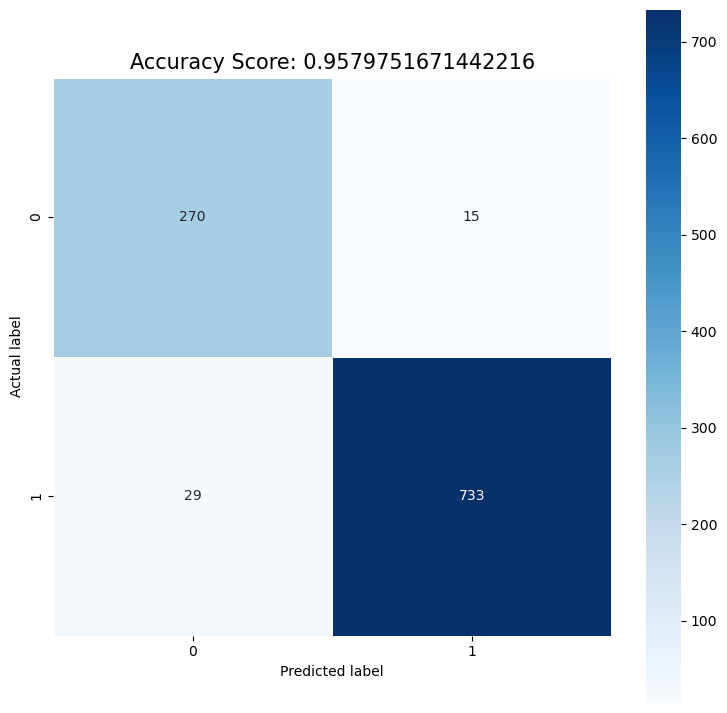

In [18]:
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15);
plt.show()

### GridSearch

I want to find the best combination of hyperparameters using k-times cross-fold validation

In [19]:
import warnings
warnings.filterwarnings("ignore")
warnings.warn("once")

logModel = LogisticRegression()

param_grid = [    
    {'penalty' : ['l2'],
    'C' : np.arange(7,9,0.05),
     'class_weight' : ['balanced'],
    'solver' : ['lbfgs','liblinear'],
    'max_iter' : [100,1000]
    }
]

clf = GridSearchCV(logModel, param_grid = param_grid, scoring='recall' ,cv = 5, verbose=True, n_jobs=1)
best_clf = clf.fit(x_train,y_train)
best_clf.best_estimator_

Fitting 5 folds for each of 160 candidates, totalling 800 fits


LogisticRegression(C=7.1499999999999995, class_weight='balanced', max_iter=1000)

In [20]:
print (f'Accuracy - : {best_clf.score(x_train,y_train):.3f}')
logisticRegr = LogisticRegression(C = 7.1499999999999995,solver = 'lbfgs',penalty="l2", class_weight='balanced',max_iter=1000)
logisticRegr.fit(x_train, y_train)
predictions = logisticRegr.predict(x_test)
accuracy = logisticRegr.score(x_test, y_test)
print("Accuracy is: " + str(accuracy))
report=classification_report(y_test,predictions)
print(report)

Accuracy - : 0.979
Accuracy is: 0.9579751671442216
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       285
           1       0.98      0.96      0.97       762

    accuracy                           0.96      1047
   macro avg       0.94      0.96      0.95      1047
weighted avg       0.96      0.96      0.96      1047



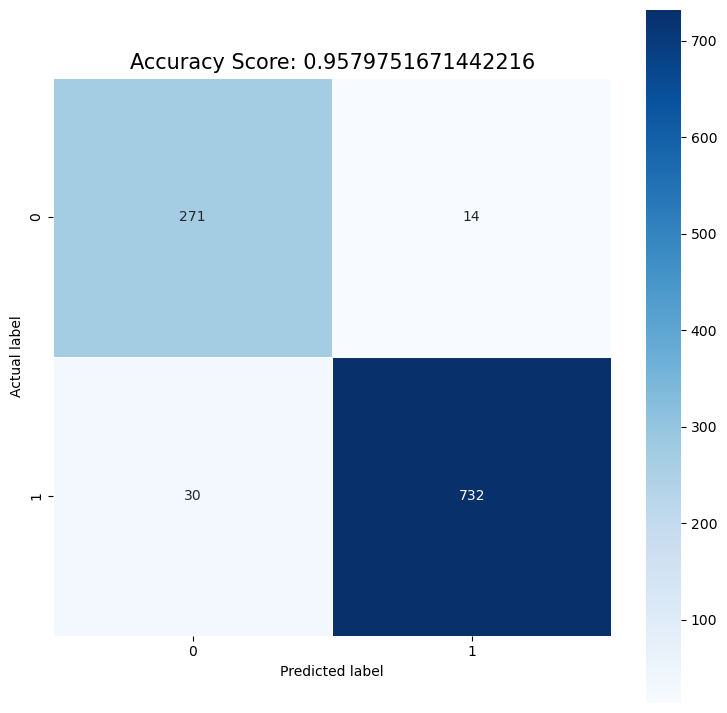

In [21]:
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=",d", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15);
plt.show()

## Random Forest

In [23]:
from sklearn.model_selection import RandomizedSearchCV

clf = RandomForestClassifier(random_state=0)


param_dist = {'n_estimators': [50,100,500,1000],
              'max_depth': [2,5,7,9,11,13,15],
             'criterion': ['log_loss']}

rand_search = RandomizedSearchCV(clf, 
                                 param_distributions = param_dist, 
                                 n_iter=10,
                                 scoring='recall',
                                 cv=5)
rand_search.fit(x_train, y_train)

print(rand_search.best_params_)

#clf.fit(x_train, y_train)
predictions = rand_search.predict(x_test)
report=classification_report(y_test,predictions)
print(report)

{'n_estimators': 100, 'max_depth': 2, 'criterion': 'log_loss'}
              precision    recall  f1-score   support

           0       0.92      0.72      0.81       285
           1       0.90      0.98      0.94       762

    accuracy                           0.91      1047
   macro avg       0.91      0.85      0.87      1047
weighted avg       0.91      0.91      0.90      1047



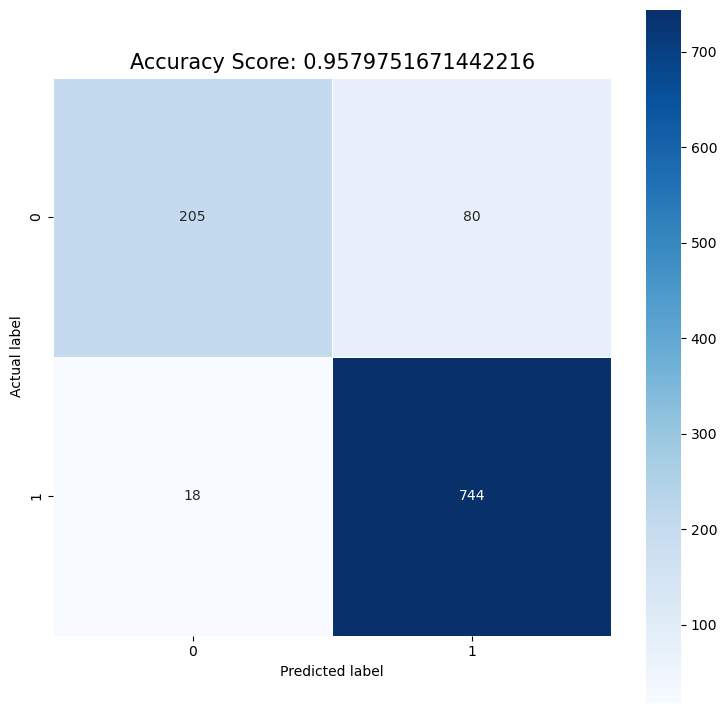

In [24]:
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=",d", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15);
plt.show()

## CNN

In [6]:
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dropout, Flatten, Dense

# Model building
model = Sequential()
# Convolutional layer with rectified linear unit activation (32 convolution filters used each of size 3x3)
model.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28, 28,1))) 

model.add(Conv2D(128, (3, 3), activation='relu'))

# Choose the best features via pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add dropout for regularization 
model.add(Dropout(0.25))

# Once we extracted the features we want to flatten the output
model.add(Flatten())

# Fully connected layer
model.add(Dense(1, activation='sigmoid'))



#Adaptive learning rate (adam) is a popular form of gradient descent rivaled only by adam and adagrad
#categorical ce since we have multiple classes (10) 
model.compile(loss=keras.losses.BinaryCrossentropy(),
              optimizer=keras.optimizers.Adam(),
              metrics=[        
                 keras.metrics.BinaryAccuracy(),
                 keras.metrics.FalseNegatives()
              ]
             )

2024-01-30 00:05:30.307732: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-30 00:05:30.348508: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
# Reshape all
new_X_train_reshaped = []
new_X_validation_reshaped = []
    
    
for i in new_X_train:
    new_X_train_reshaped.append(i.reshape(28,28,1))
for i in new_X_validation:
    new_X_validation_reshaped.append(i.reshape(28,28,1))
    
    

# x_train, x_test, y_train, y_test = train_test_split(np.array(X_reshaped), y, test_size=0.2, random_state=0)
print(np.shape(x_train[0]))

# Early stopping
callback = keras.callbacks.EarlyStopping(monitor='loss',patience = 3)
# keras_tuner

batch_size = 16
num_epoch = 128
#model training
model_log = model.fit(np.array(new_X_train_reshaped), new_Y_train,
                      batch_size=batch_size,
                      epochs=num_epoch,
                      verbose=1,
                      validation_data=(np.array(new_X_validation_reshaped), new_Y_validation),
                     callbacks=[callback])

(784,)
Epoch 1/128
197/197 [==============================] - 3s 11ms/step - loss: 0.3229 - binary_accuracy: 0.8620 - false_negatives: 76.0000 - val_loss: 0.1795 - val_binary_accuracy: 0.9341 - val_false_negatives: 16.0000
Epoch 2/128
197/197 [==============================] - 2s 9ms/step - loss: 0.1726 - binary_accuracy: 0.9315 - false_negatives: 89.0000 - val_loss: 0.1592 - val_binary_accuracy: 0.9427 - val_false_negatives: 42.0000
Epoch 3/128
197/197 [==============================] - 2s 10ms/step - loss: 0.1472 - binary_accuracy: 0.9372 - false_negatives: 86.0000 - val_loss: 0.1375 - val_binary_accuracy: 0.9513 - val_false_negatives: 31.0000
Epoch 4/128
197/197 [==============================] - 2s 9ms/step - loss: 0.1338 - binary_accuracy: 0.9503 - false_negatives: 73.0000 - val_loss: 0.1248 - val_binary_accuracy: 0.9513 - val_false_negatives: 21.0000
Epoch 5/128
197/197 [==============================] - 2s 9ms/step - loss: 0.1138 - binary_accuracy: 0.9560 - false_negatives: 56.0

In [20]:
x_test_reshaped = []
    
    
for i in x_test:
    x_test_reshaped.append(i.reshape(28,28,1))
print(np.shape(x_test_reshaped))
print(np.shape(y_test))
print(x_test_reshaped)

score = model.evaluate(np.array(x_test_reshaped), y_test, verbose=1)
print('Test:', score) 

(1047, 28, 28, 1)
(1047,)


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



33/33 [==============================] - 0s 11ms/step - loss: 0.0785 - binary_accuracy: 0.9742 - false_negatives: 17.0000
Test: [0.07848712056875229, 0.9742120504379272, 17.0]


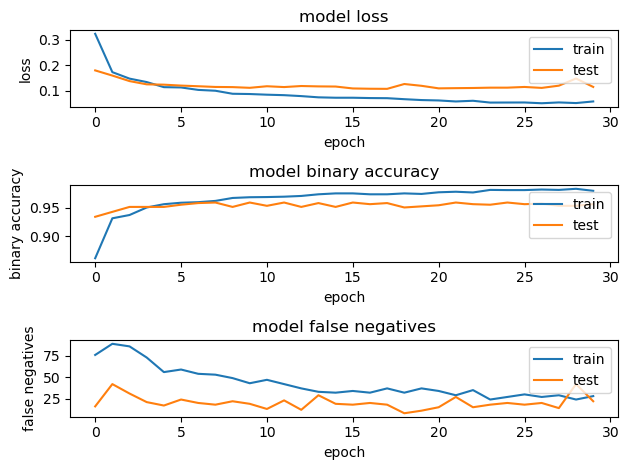

In [21]:
fig = plt.figure()
plt.subplot(3,1,1)
plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.subplot(3,1,2)

plt.plot(model_log.history['binary_accuracy'])
plt.plot(model_log.history['val_binary_accuracy'])
plt.title('model binary accuracy')
plt.ylabel('binary accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.subplot(3,1,3)
plt.plot(model_log.history['false_negatives'])
plt.plot(model_log.history['val_false_negatives'])
plt.title('model false negatives')
plt.ylabel('false negatives')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

33/33 [==============================] - 0s 7ms/step
755
(1047, 28, 28, 1)
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
(1047, 1)


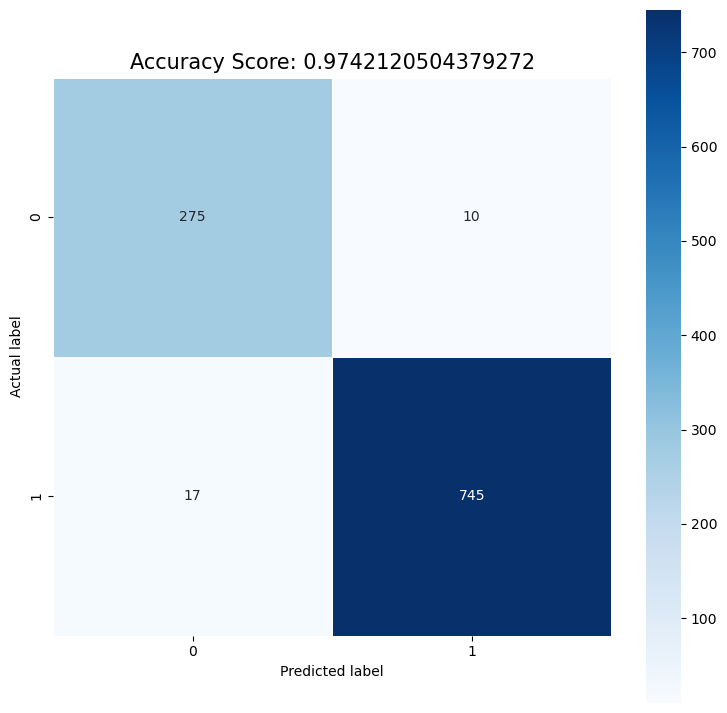

In [24]:

    
predictions = model.predict(np.array(x_test_reshaped) )

k = 0
for i in predictions:
    if i[0] > 0.5:
        k = k+1
        
print(k)
print(np.shape(np.array(x_test_reshaped)))
predictions = np.round(predictions)
print(predictions)

print(np.shape(predictions))

cm = metrics.confusion_matrix(y_test, predictions)



plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=",d", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score[1])
plt.title(all_sample_title, size = 15);
plt.show()

## Conclusions